In [360]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [361]:
sales_data = pd.read_csv('/home/hasan/Downloads/train.csv')

In [362]:
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [363]:
sales_data.shape

(913000, 4)

# Feature Engineering

In [364]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [365]:
#converting to datetime of date column
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [366]:
#finding monthly sales
sales_data['date'] = sales_data['date'].dt.year.astype('str')+ '-' + sales_data['date'].dt.month.astype('str')+ '-01'
sales_data['date'] = pd.to_datetime(sales_data['date'])
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,1,11
2,2013-01-01,1,1,14
3,2013-01-01,1,1,13
4,2013-01-01,1,1,10


In [367]:
sales_data = sales_data.groupby('date').sales.sum().reset_index()
sales_data.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


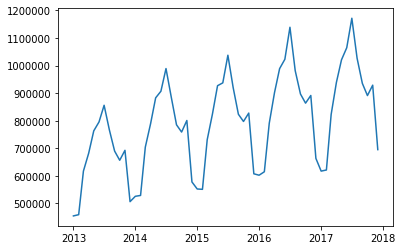

In [368]:
#checking is dataset is stationary or seasonal
plt.plot(sales_data['date'], sales_data['sales'])

It is clear that in the beginning of the year sales reduced in lowest but at the middle of the year sales increase.This process is continue. 

For this we can say the datset is seasonal.

In [369]:
#creating a new dataframe to model the difference
sales_diff = sales_data.copy()

#adding previous sales to the next row
sales_diff['prev_sales'] = sales_diff['sales'].shift(1)

#dropping the null value and calculating the difference
sales_diff.dropna(axis=0, inplace=True)
sales_diff['diff'] = (sales_diff['sales'] - sales_diff['prev_sales'])
sales_diff.head(10)

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0
6,2013-07-01,855922,795597.0,60325.0
7,2013-08-01,766761,855922.0,-89161.0
8,2013-09-01,689907,766761.0,-76854.0
9,2013-10-01,656587,689907.0,-33320.0
10,2013-11-01,692643,656587.0,36056.0


In [370]:
sales_diff.tail(10)

,date,sales,prev_sales,diff
50,2017-03-01,822667,621369.0,201298.0
51,2017-04-01,938862,822667.0,116195.0
52,2017-05-01,1020686,938862.0,81824.0
53,2017-06-01,1064624,1020686.0,43938.0
54,2017-07-01,1171393,1064624.0,106769.0
55,2017-08-01,1026403,1171393.0,-144990.0
56,2017-09-01,935263,1026403.0,-91140.0
57,2017-10-01,891160,935263.0,-44103.0
58,2017-11-01,928837,891160.0,37677.0
59,2017-12-01,695170,928837.0,-233667.0


Text(0.5, 1.0, 'Monthly sales difference')

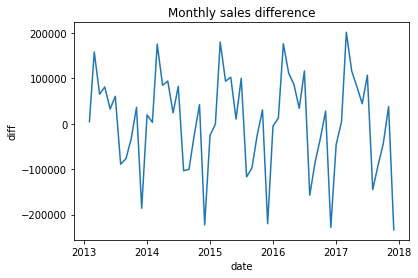

In [371]:
#checking is dataset is stationary or seasonal
plt.plot(sales_diff['date'], sales_diff['diff'])
plt.xlabel('date')
plt.ylabel('diff')
plt.title('Monthly sales difference')

In [372]:
# We need to use previous monthly sales data to forecast the next ones. The look-back period may vary 
#for every model. Ours will be 12 for this example.

#So what we need to do is to create columns from lag_1 to lag_12 and assign values by using shift() method:

#create dataframe for transformation from time series to supervised
sales_supervised = sales_diff.drop(['prev_sales'], axis=1)

#adding lags
for inc in range(1,13):
    name = 'lag_'+str(inc)
    sales_supervised[name] = sales_supervised['diff'].shift(inc)
    
sales_supervised.head()

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1,2013-02-01,459417,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-01,617382,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-01,682274,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-01,763242,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-06-01,795597,32355.0,80968.0,64892.0,157965.0,4513.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
#dropping the null value
sales_supervised = sales_supervised.dropna().reset_index(drop=True)
sales_supervised

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


We have our feature set now. Let’s be a bit more curious and ask this question:

How useful are our features for prediction?

In [374]:
#dropping date and sales column from sales_supervised
sales_model = sales_supervised.drop(['date','sales'], axis=1)

#we will predict last six months sale
#spliting train and test set
train_set, test_set = sales_model[0:-6].values, sales_model[-6:].values
print('Shape of train_set :',train_set.shape)
print('Shape of test_set :',test_set.shape)

Shape of train_set : (41, 13)
Shape of test_set : (6, 13)


In [375]:
#scalling the train datset.
#I am using MinMaxScaler, which gives the result between -1 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_set)

#reshaping train and test data
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])

#transforming with MinMaxScaler
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)
print('Shape of train_set_scaled :',train_set_scaled.shape)
print('Shape of test_set_scaled :',test_set_scaled.shape)


Shape of train_set_scaled : (41, 13)
Shape of test_set_scaled : (6, 13)


In [376]:
#splitting train, test dataset into train,test,label

xtrain, ytrain = train_set_scaled[:,1:], train_set_scaled[:,0]
xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])

xtest,ytest = test_set_scaled[:,1:], test_set_scaled[:,0]
xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])
print('Shape of xtrain :',xtrain.shape)
print('Shape of xtest :',xtest.shape)

Shape of xtrain : (41, 1, 12)
Shape of xtest : (6, 1, 12)


# Model

In [377]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, xtrain.shape[1], xtrain.shape[2]), stateful=True))
model.add(Dense(1))

In [378]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (1, 4)                    272       
_________________________________________________________________
dense_10 (Dense)             (1, 1)                    5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [379]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [380]:
model_history = model.fit(xtrain,ytrain, epochs=100, verbose=1, batch_size=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 1s 13ms/step - loss: 0.4323
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2076
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1622
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1364
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1193
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1062
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0851
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0762
Epoch 11/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0681
Epoch 12/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0608
Epoch 13/100
41/41 [================

In [381]:
#predicting with test data
predicted = model.predict(xtest, batch_size=1)
predicted

array([[ 0.6128965 ],
       [-0.58669186],
       [-0.35873386],
       [-0.00229504],
       [ 0.23240831],
       [-0.9744285 ]], dtype=float32)

Those data are totally not understandable because those are scaled data. 

In [382]:
#How we can see the actual sales prediction?
#First, we need to do the inverse transformation for scaling:

#reshaping of predicted data
predicted = predicted.reshape(predicted.shape[0], 1, predicted.shape[1])

predicted_test_set = []
for index in range(len(predicted)):
    print(np.concatenate([predicted[index], xtest[index]], axis=1))
    predicted_test_set.append(np.concatenate([predicted[index], xtest[index]], axis=1))

[[ 0.6128965   0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.58669186  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.35873386 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[-0.00229504 -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.23240831 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-0.97442847  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [383]:
#reshaping predicted_test_set
predicted_test_set = np.array(predicted_test_set)
predicted_test_set = predicted_test_set.reshape(predicted_test_set.shape[0], predicted_test_set.shape[2])
print('Shape of predicted_test_set :',predicted_test_set.shape)

#inverse transform
predicted_test_set_inversed = scaler.inverse_transform(predicted_test_set)
print('Shape of predicted_test_set_inverse :',predicted_test_set_inversed.shape)

Shape of predicted_test_set : (6, 13)
Shape of predicted_test_set_inverse : (6, 13)


In [384]:
len(predicted_test_set_inversed)

6

In [388]:
#Second, we need to build the dataframe has the dates and the predictions. Transformed predictions are showing 
#the difference. We should calculate the predicted sales numbers:

result = []
sales_date = list(sales_diff[-7:].date)
sales = list(sales_diff[-7:].sales)
print(len(sales_date))
print(len(sales))

for index in range(0, len(predicted_test_set_inversed)):
    result_dict = {}
    result_dict['pred_value'] = int(predicted_test_set_inversed[index][0] + sales[index])
    result_dict['date'] = sales_date[index+1]
    result.append(result_dict)
    
predicted_result = pd.DataFrame(result)
predicted_result.head()

7
7


,pred_value,date
0,1182823,2017-07-01
1,1032079,2017-08-01
2,936024,2017-09-01
3,921400,2017-10-01
4,927681,2017-11-01


Great! We’ve predicted the next six months’ sales numbers. 

Let’s check them in the plot to see how good is our model:

In [389]:
predicted_sales = pd.merge(sales_diff,predicted_result, on='date', how='left')

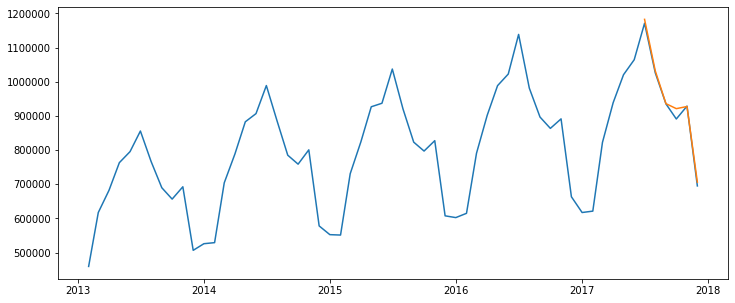

In [390]:
plt.figure(figsize=(12,5))
plt.plot(predicted_sales['date'], predicted_sales['sales'])
plt.plot(predicted_sales['date'], predicted_sales['pred_value'])
